# Tensor Network Workshop - Benasque Spring School on Near-Term Quantum Computing

First, let's install the required libraries:


In [1]:
using Pkg
pkg"registry add https://github.com/bsc-quantic/Registry"

Pkg.add("Tenet")
Pkg.add("EinExprs")
Pkg.add("Quac")
Pkg.add(url="https://github.com/bsc-quantic/Qrochet.jl.git")

# For plotting
Pkg.add("CairoMakie") 

┌ Warning: The Pkg REPL mode is intended for interactive use only, and should not be used from scripts. It is recommended to use the functional API instead.
└ @ Pkg.REPLMode /home/jofrevalles/.julia/juliaup/julia-1.10.2+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/REPLMode/REPLMode.jl:382
     Cloning registry from "https://github.com/bsc-quantic/Registry"
Registry `Quantic` already exists in `~/.julia/registries/Quantic`.
   Resolving package versions...
  No Changes to `~/git/benasque-notebook/Project.toml`
  No Changes to `~/git/benasque-notebook/Manifest.toml`
   Resolving package versions...
  No Changes to `~/git/benasque-notebook/Project.toml`
  No Changes to `~/git/benasque-notebook/Manifest.toml`
   Resolving package versions...
  No Changes to `~/git/benasque-notebook/Project.toml`
  No Changes to `~/git/benasque-notebook/Manifest.toml`
    Updating git-repo `https://github.com/bsc-quantic/Qrochet.jl.git`
   Resolving package versions...
  No Changes to `~/git/benasque-no

In [3]:
using Quac
using Tenet
using EinExprs
using Qrochet
using CairoMakie

Let's start with creating a simple quantum circuit:

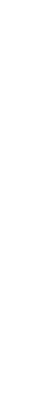

In [4]:
using Quac

n_qubits = 8
circ = Circuit(n_qubits)

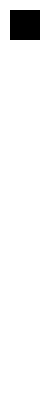

In [41]:
push!(circ, H(1))
circ

Now let's create a simple quantum circuits with `10` qubits and `4` layers of random gates.

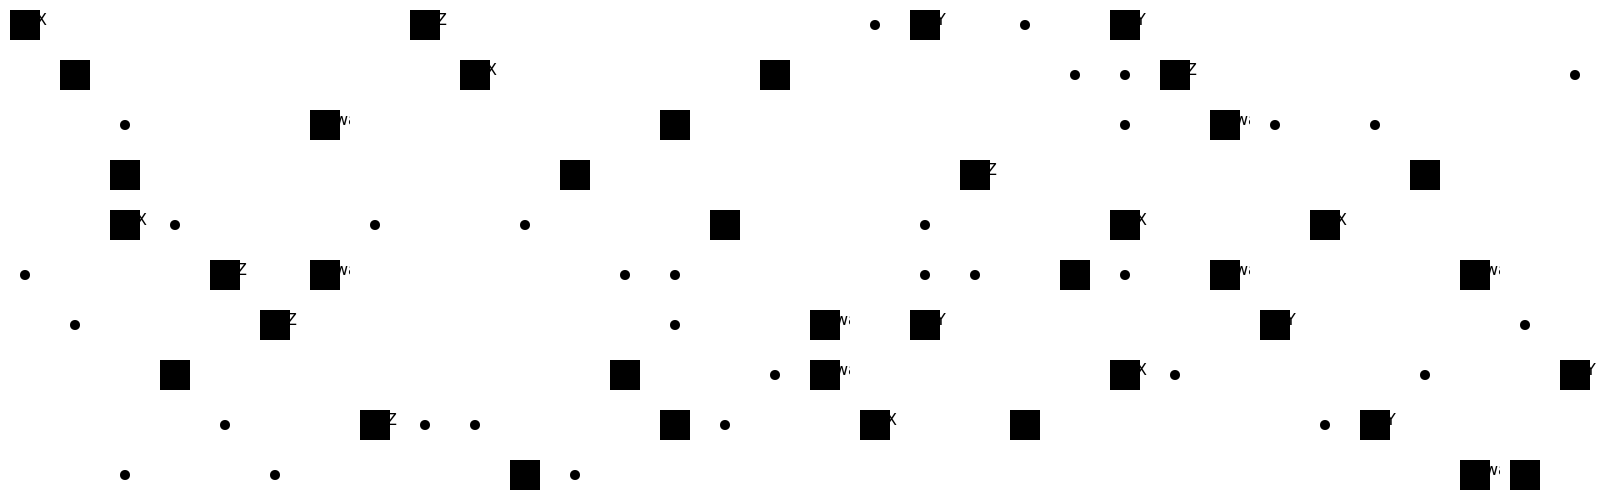

In [42]:
using Quac

n = 10
depth = 4

# Define the quantum circuit
circ = Circuit(n)
gates = [Swap, CX, CY, CZ, CRx, CRy, CRz]
for j in 1:depth
    for i in 1:n
        # We want to apply some entangling gates
        k = rand(1:n)
        gate = gates[rand(1:length(gates))]
        if k != i
            push!(circ, gate(k, i))
        end
    end
end

circ

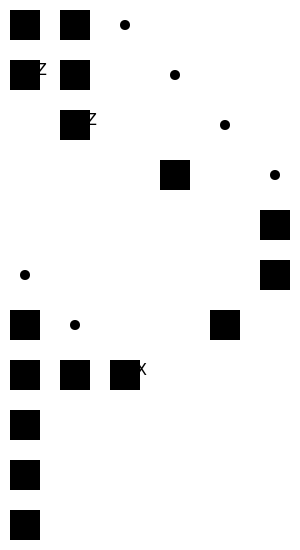

In [43]:
using Quac

# Set the number of qubits and the depth of the circuit
n = 8
depth = 2

# Define the quantum circuit
circ = Circuit(n)
single_qubit_gates = [X, Y, Z, H]  # List of possible single-qubit gates
two_qubit_gates = [Swap, CX, CY, CZ, CRx, CRy, CRz]   # List of possible two-qubit gates

# Populate the circuit with a mix of single and two-qubit random gates
for layer in 1:depth
    for qubit in 1:n
        if rand() < 0.5
            # 50% chance to add a single-qubit gate
            gate = single_qubit_gates[rand(1:length(single_qubit_gates))]
            push!(circ, gate(qubit))  # Example angle π/4, modify as needed
        else
            # 50% chance to add a two-qubit gate
            partner = rand(setdiff(1:n, qubit))
            gate = two_qubit_gates[rand(1:length(two_qubit_gates))]
            push!(circ, gate(partner, qubit))
        end
    end
end

# Display the created circuit
circ

Now that we have created a circuit, let's convert it to a tensor network with `Tenet`

In [44]:
using Tenet
using Qrochet

qtn = Quantum(circ)
tn = TensorNetwork(qtn)
tn

TensorNetwork (#tensors=16, #inds=30)

We can use `CairoMakie` to visualize the tensor network:

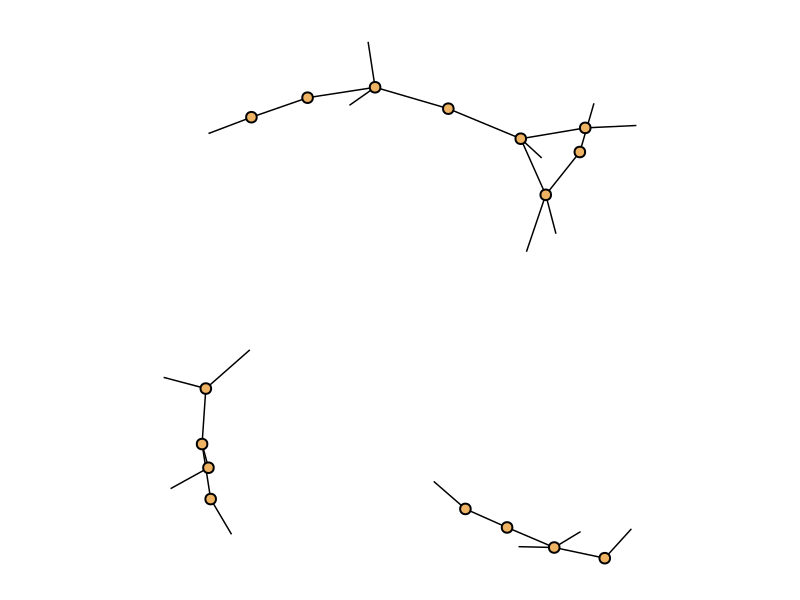

In [45]:
using CairoMakie

plot(tn)

We get a `Tensor Network` object that contains the tensor network representation of the circuit. It has $2N$ open indices, where $N$ is the number of qubits in the circuit, since we need to connect the input and output  qubits of the circuit to the tensor network. We will now contract the tensor network with the initial and final states to get the expectation value of the circuit.

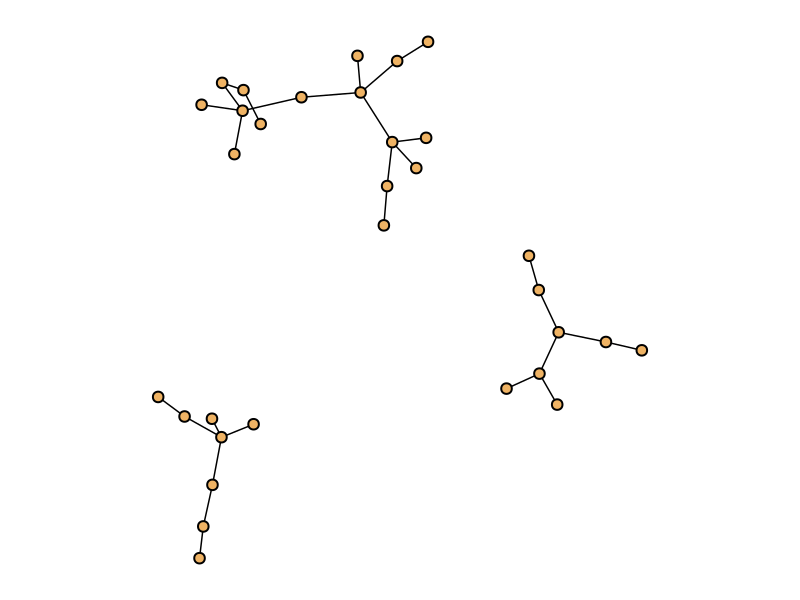

In [46]:
ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))
plot(tn)

We can use `EinExprs.jl` to see the contraction path of the tensor network:

In [47]:
using EinExprs

path = einexpr(tn, optimizer=Greedy())
total_flops = mapreduce(flops, +, Branches(path))
max_dims = maximum(ndims, Branches(path))

total_flops, max_dims

(323, 4)

We can also plot the contraction path:

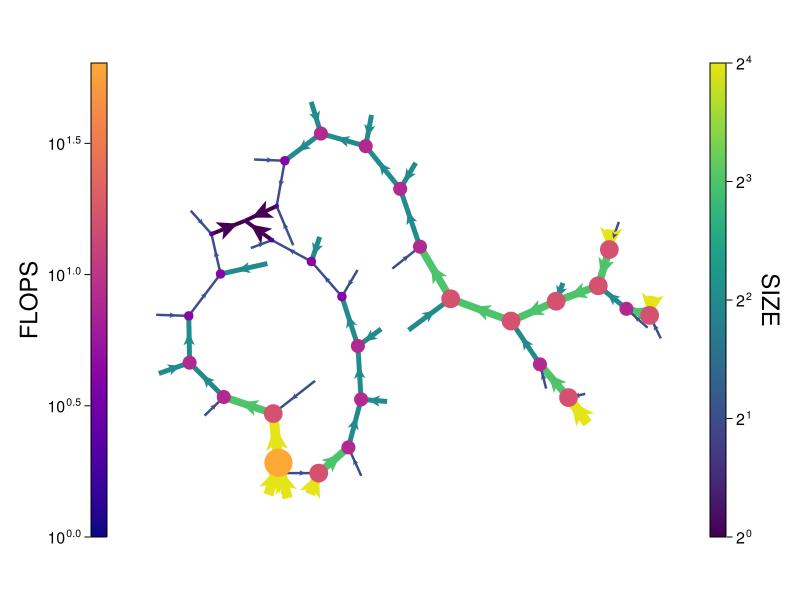

In [48]:
plot(path)

Okay! Let's contract the circuit:

In [49]:
qtn = Quantum(circ)

ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ)))

0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
0.0 + 0.0im

Let's create a more complex circuit that is made of two-qubit local gates:

In [43]:
using Quac

n = 50
depth = 10

# Define the quantum circuit
gates = [Rxx, Ryy, Rzz]
circ = Circuit(n)
for i in 1:depth
    for j in 1:n
        if j < n
            rand_gate = gates[rand(1:length(gates))]
            push!(circ, rand_gate(j, j+1; θ=rand()*2π))
        end     
    end
end

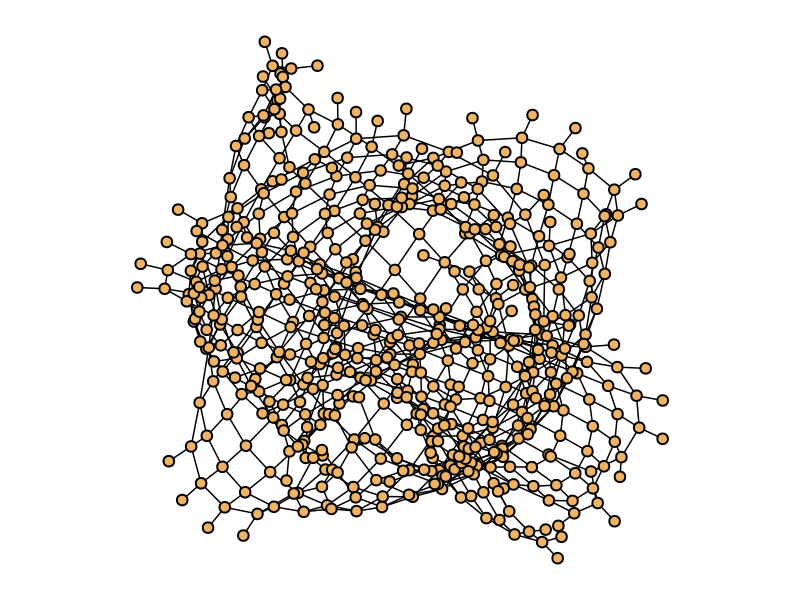

In [45]:
qtn = Quantum(circ)
    
ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

tn = merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ))

plot(tn)

In [46]:
path = einexpr(tn, optimizer=Greedy())

total_flops = mapreduce(flops, +, Branches(path))
max_dims = maximum(ndims, Branches(path))

total_flops, max_dims

(288449616, 18)

Much larger circuit!! We need an approximation! We will use MPS

In [47]:
ψᵢₙ = Product(fill([1, 0], n))
ψₒᵤₜ = Product(fill([1, 0], n))

qtn = Quantum(circ)

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

@time c = contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(qtn), TensorNetwork(ψₒᵤₜ)))

  3.420234 seconds (4.37 M allocations: 418.758 MiB, 5.44% gc time, 84.79% compilation time)


0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
-1.0661624413952514e-8 + 1.7689564784071112e-10im

In [37]:
ψᵢₙ = convert(Chain, Product(fill([1, 0], n)))
ψₒᵤₜ = convert(Chain, Product(fill([1, 0], n)))

Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

# canonize!(ψᵢₙ)
# ψₒᵤₜ = convert(Chain, Product(fill([1, 0], n)))

# Apply gates using `evolve!` function  

for gate in circ
    evolve!(ψᵢₙ, Qrochet.Dense(gate); maxdim=2, iscanonical=false)
end

Qrochet.@reindex! outputs(ψᵢₙ) => outputs(ψₒᵤₜ)

contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(ψₒᵤₜ)))


0-dimensional Tensor{ComplexF64, 0, Array{ComplexF64, 0}}:
-8.63200530542845e-16 + 9.843087028404434e-16im

We can limit the bond dimension of the MPS to the computational complexity of the operation. A limit in the bond dimension can be thought as a limit in the entanglement of the state. The bond dimension is a trade-off between accuracy and computational cost. The larger the bond dimension, the more accurate the approximation, but the more expensive the computation.

Let's use a reduced bond dimension $\chi$ and compare it with the exact result.

In [48]:
# Let's evolve for different bond dimensions χ and compare to the exact result
results = ComplexF32[]
χ_list = [2, 4, 8, 16, 32, 64,]
for χ in χ_list
    ψᵢₙ = convert(Chain, Product(fill([1, 0], n)))
    ψₒᵤₜ = convert(Chain, Product(fill([1, 0], n)))
    canonize!(ψᵢₙ)

    Qrochet.@reindex! inputs(qtn) => outputs(ψᵢₙ)
    Qrochet.@reindex! outputs(qtn) => outputs(ψₒᵤₜ)

    for gate in circ
        evolve!(ψᵢₙ, Qrochet.Dense(gate); maxdim=χ, iscanonical=true)
    end

    Qrochet.@reindex! outputs(ψᵢₙ) => outputs(ψₒᵤₜ)

    push!(results, only(contract(merge(TensorNetwork(ψᵢₙ), TensorNetwork(ψₒᵤₜ)))))
end

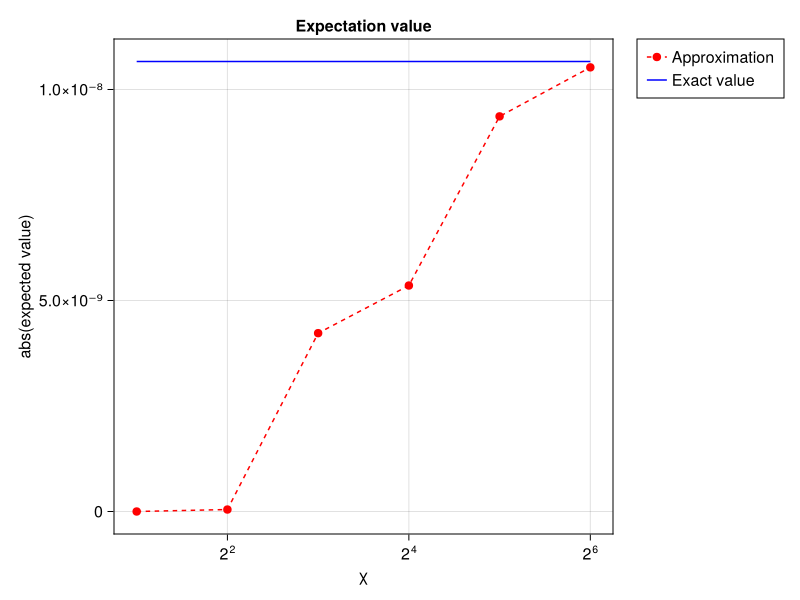

In [49]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="χ", ylabel="abs(expected value)", title="Expectation value", xscale=log2)

scatterlines!(ax, Float32.(χ_list), abs.(results), color=:red, linestyle=:dash, marker=:circle, label="Approximation")
lines!(ax, Float32.(χ_list), abs(only(c))*ones(length(χ_list)), color=:blue, linestyle=:solid, label="Exact value")

# Adjust the legend manually
legend = Legend(fig[1, 2], ax, valign=:top)
fig[1, 2] = legend

fig # Display the figure

### Time Evolution of a Matrix Product State

We will use the `Time Evolving Block Decimation (TEBD)` algorithm to simulate the time evolution of a Matrix Product State (MPS) circuit.

##### Transverse-field Ising Model

The Hamiltonian of transverse field Ising model is given by:
$H = -\sum_{\braket{i,j}} \sigma_{X}^{(i)} \sigma_{X}^{(j)} + \lambda \sum_i \sigma_Z^{(i)}$

We will simulate the time evolution of a quantum state under this Hamiltonian, and we will measure some `observables` of the system.

In the `TEBD` algorithm we will use the Suzuki-Trotter decomposition to the first order, which approximates $e^{-iHt}$ as $e^{-iH_1 \Delta t} e^{-iH_2 \Delta t} ... e^{-iH_n \Delta t}$, where $H = H_1 + H_2 + ... + H_n$, where $\Delta t$ is the time step.

In [58]:
observables = Dense.([Z(5)])

n = 10
δₜ = 0.1
timesteps = 80

80

We define two gates that will be used. The `trotter_XX` gate is a Trotterized version of the XX gate, and the `trotter_Z` gate is a Trotterized version of the Z gate.

In [59]:
function trotter_XX(i,j; δₜ=δₜ)
    mat = kron(Matrix(X()), Matrix(X()))
    mat = cis(δₜ * mat)
    mat = reshape(mat,2,2,2,2)
    Dense(Qrochet.Operator(), mat; sites=Site[Site(i), Site(j), Site(i, dual=true), Site(j, dual=true)])
end

function trotter_Z(i; λ, δₜ=δt)
    mat = Matrix(Z())
    mat = cis(- λ * δₜ * mat)

    Dense(Qrochet.Operator(), mat; sites=Site[Site(i), Site(i, dual=true)])
end

trotter_Z (generic function with 1 method)

We start the quench from a product state where all qubits are in the $|+\rangle$ state.

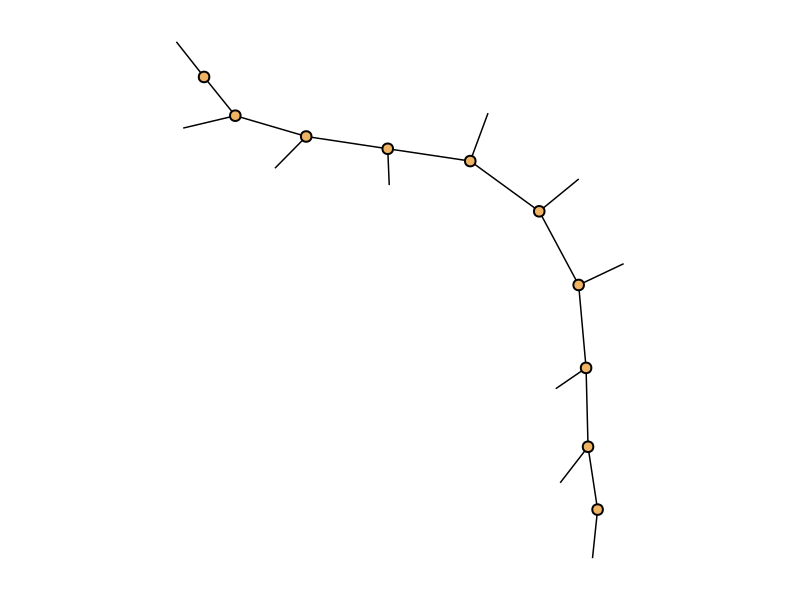

In [60]:
ket₊ = 1/√2 * [1, 1]
ψ = Product(fill(ket₊, n))
ψ = convert(Chain, ψ)

plot(TensorNetwork(ψ))

In [61]:
# Time evolution:
expected_vals = Float64[]
@time for it in 1:timesteps
    # First apply the gates on even qubits
    for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(1:n,2))
        evolve!(ψ, trotter_XX(i,j; δₜ))
    end

    # Then apply the gates on odd qubits
    for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(2:n,2))
        evolve!(ψ, trotter_XX(i,j; δₜ))
    end

    # Finally apply the one-qubit gates
    for i in 1:n
        evolve!(ψ, trotter_Z(i; λ=0.3, δₜ))
    end

    # Compute the expectation value of the observable
    push!(expected_vals, abs(only(expect(ψ, observables))))
end

 27.638301 seconds (5.90 M allocations: 486.560 MiB, 0.55% gc time, 0.31% compilation time)


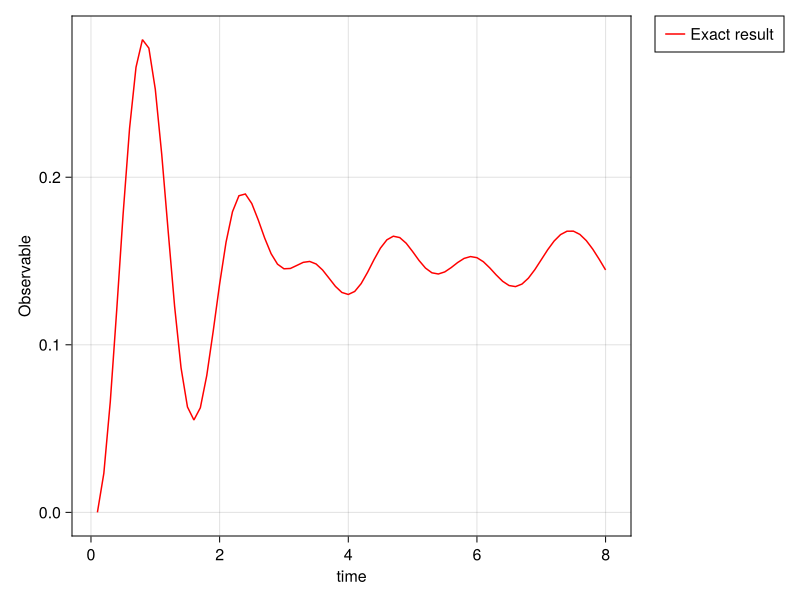

In [62]:
# Plot the expectation value:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="time", ylabel="Observable")
lines!(ax, (1:timesteps) .* δₜ, expected_vals, color=:red, linestyle=:solid, marker=:circle, label="Exact result", fontsize=12)

legend = Legend(fig[1, 2], ax, valign=:top)
fig

But what if we have a large system? We can limit the bond dimension $\chi$!

In [65]:
expectedvals = Dict()

ket₊ = 1/√2 * [1, 1]
ψ_original = convert(Chain, Product(fill(ket₊, n)))

observables = Dense.([Z(5)])

maxdims = [1, 2, 4, 8, 16]

for maxdim in maxdims
    # Reset ψ to its original state for each maxdim iteration
    ψ = deepcopy(ψ_original)
    canonize!(ψ)
    expectedvals_maxdim = Float64[]

    @time for it in 1:timesteps
        for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(1:n,2))
            evolve!(ψ, trotter_XX(i,j; δₜ); maxdim=maxdim, iscanonical=true)
        end
        for (i,j) in Iterators.filter(==(2) ∘ length, Iterators.partition(2:n,2))
            evolve!(ψ, trotter_XX(i,j; δₜ); maxdim=maxdim, iscanonical=true)
        end
        for i in 1:n
            evolve!(ψ, trotter_Z(i; λ=0.3, δₜ); maxdim=maxdim, iscanonical=true)
        end
        push!(expectedvals_maxdim, abs(only(expect(ψ, observables))))
    end

    expectedvals[maxdim] = expectedvals_maxdim
end

MethodError: MethodError: no method matching iterate(::Nothing)

Closest candidates are:
  iterate(!Matched::Combinatorics.CoolLexCombinations)
   @ Combinatorics ~/.julia/packages/Combinatorics/Udg6X/src/combinations.jl:87
  iterate(!Matched::Combinatorics.CoolLexCombinations, !Matched::Combinatorics.CoolLexIterState)
   @ Combinatorics ~/.julia/packages/Combinatorics/Udg6X/src/combinations.jl:106
  iterate(!Matched::DataStructures.IntSet)
   @ DataStructures ~/.julia/packages/DataStructures/aD5vv/src/int_set.jl:171
  ...


In [64]:
using CairoMakie

# Assuming `expectedvals` and `maxdims` are defined as before

fig = Figure()
ax = Axis(fig[1, 1], xlabel="Timestep", ylabel="Observable", title="Observables for Different maxdim")

# Reverse the order of these arrays to match the reversed maxdims
color_palette = reverse([:red, :green, :blue, :purple, :orange])
line_styles = reverse([(:solid, 2), (:dash, 2), (:dot, 2), (:dashdot, 2), (:dashdotdot, 2)])
markers = reverse([:circle, :square, :diamond, :cross, :star])

# Reverse the order of iteration for maxdims
for (index, maxdim) in enumerate(maxdims)
    # Convert expectedvals[maxdim] to a Float32 array explicitly
    y_values = Float32.(expectedvals[maxdim])
    x_values = Float32.(1:length(y_values)) # Ensure x values are also Float32 for consistency

    lines!(ax, x_values, y_values,
          color=color_palette[index],
          linestyle=line_styles[index][1],
          linewidth=line_styles[index][2],
          marker=markers[index],
          markersize=10,
          label="maxdim = $maxdim")
end

legend = Legend(fig[1, 2], ax, valign=:top)
fig[1, 2] = legend

fig # Display the figure

KeyError: KeyError: key 16 not found